In [1]:
import os
import torch
# import wandb
# from torchinfo import summary
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
# import argparse
import torchvision.models as models
import pandas as pd
# import skimage as ski
from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision.transforms import v2 as transforms
import matplotlib.pyplot as plt
import numpy as np

In [140]:
!pip install torchvision

  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparselt_cu12-0.6.2-py3-none-manylin

In [2]:
# Need indigene-img2 environment to plot umap
# tensorflow error that requires python > 3.11.0
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.python.framework import ops

2025-02-24 20:51:51.984726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740430312.043328 4055310 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740430312.074672 4055310 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 20:51:53.085507: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# import umap
import scanpy as sc

In [2]:
! module load cuda/12.2.0

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [139]:
from models import VariationalAutoEncoderResNet, VariationalAutoEncoderConv

vae = VariationalAutoEncoderConv((1, 224, 224), latent_dim=128)
# summary(vae, (1, 1, 224, 224))

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
# Create dataloader
class MedakaDataset(Dataset):
    """
    Custom dataset class for the medaka fish images.

    Attributes:
        image_paths (pd.Series):
            Pandas Series containing the paths to the images.
        src_dir (str):
            Directory containing the images.
        transform (Compose):
            Compose object containing the transformations to apply.
        direction_csv (str):
            Path to the CSV file containing whether the fish
            are facing left or right.
    """

    def __init__(self, data_csv, direction_csv, src_dir, transform):
        self.image_paths = pd.read_csv(data_csv)['img_name']
        self.src_dir = src_dir
        self.transform = transform

        # Load and process the CSV file containing the direction of the fish
        self.direction_csv = pd.read_csv(direction_csv)
        self.direction_csv = self.direction_csv[
            self.direction_csv['left_facing'] == 'left']
        self.direction_csv = self.direction_csv.rename(
            columns={'Unnamed: 0': 'img_name'})

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_base_name = os.path.splitext(img_name)[0]
        img_path = f'{self.src_dir}/raw_images/{img_name}'
        mask_path = f'{self.src_dir}/train_ilastik-masks-05112024/{img_base_name}_Simple Segmentation.tif'
        
        image = ski.io.imread(img_path)[:, :, 0]
        
        mask = ski.io.imread(mask_path)

        # Apply transformations
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        img_base_name = os.path.splitext(img_name)[0]
        if img_base_name in self.direction_csv['img_name'].values:
            image = transforms.functional.hflip(image)

        ### Manual adjustments to odd images in training set
        # Manually flip the images where the fish head is facing down
        if img_name in ['PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E04.tif', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_H7.tif']:
            image = transforms.functional.hflip(image)
            image = transforms.functional.vflip(image)

        # These fish are horizontal in the original image, so rotate them 45 degrees
        if img_name in ['PLATE 2 F2 VC_Male 95-1 F14 x Female 129-1 F14_D5.tif',
                        'PLATE 6 F2 VC_ Female 95-1 F14 x Male 72-1 F14_G5.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G1.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G4.tif',
                        'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_G9.tif']:
            image = transforms.functional.rotate(image, 45)

        return image, img_name

In [ ]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)
checkpoint = torch.load("/hps/nobackup/birney/users/esther/medaka-img/models/checkpoints/vae-pytorch-medaka/tough-donkey-26/ckpt-model-convnet-vae-run-tough-donkey-26-epoch-299-time-2025-02-20-1619.pt")

In [ ]:
vae.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
from data import MinMaxScaling
import data

dataset = MedakaDataset(data_csv='/nfs/research/birney/users/esther/medaka-img/src_files/train_set_2024-10-03 copy.csv',
                        direction_csv='/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv', 
                        src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/', 
                        transform=data.transform()
                        )

In [ ]:
len(dataset)

In [ ]:
vae.eval()
mean_matrix = {}
var_matrix = {}
counter = 0

for image, image_name in dataset:
    image = torch.tensor(image).to(device)  # Convert image to a PyTorch tensor
    mean, var = vae.get_latent(image.unsqueeze(0))
    mean_matrix[image_name] = mean.detach().cpu().numpy().reshape(128)
    var_matrix[image_name] = var.detach().cpu().numpy().reshape(128)

    if counter % 10 == 0:
        print(counter)

    counter += 1

In [ ]:
len(mean_matrix)

In [ ]:
mean_df = pd.DataFrame.from_dict(mean_matrix, orient='index')
var_df = pd.DataFrame.from_dict(var_matrix, orient='index')

mean_df.to_csv('/nfs/research/birney/users/esther/medaka-img/features/convnet-vae-pytorch-medaka/tough-donkey-26-epoch299/mean_matrix.csv')
var_df.to_csv('/nfs/research/birney/users/esther/medaka-img/features/convnet-vae-pytorch-medaka/tough-donkey-26-epoch299/var_matrix.csv')

In [ ]:
print(mean_df) # 128-length latent vector for each image

In [5]:
var_df = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/features/convnet-vae-pytorch-medaka/tough-donkey-26-epoch299/var_matrix.csv')
var_df = var_df.set_index('Unnamed: 0')

In [49]:
var_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif,-13.917355,-23.018187,-17.178904,-26.551586,-17.749876,-17.131168,-21.607730,-15.262320,-13.509216,-25.861374,...,-54.493217,-29.050325,-20.228386,-12.353735,-28.898200,-18.401380,-28.843683,-19.564106,-22.443104,-15.834898
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A10.tif,-13.224632,-8.039904,-13.840871,-21.726254,-16.019415,-16.349379,-19.973583,-15.837339,-9.413135,-20.836721,...,-46.547737,-20.411274,-17.951927,-11.866353,-17.782291,-16.163937,-23.943022,-14.764634,-17.770542,-13.611662
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A12.tif,-13.344997,-26.731989,-17.650719,-25.319592,-14.297226,-15.601287,-18.427666,-17.629745,-12.096087,-24.635778,...,-54.089653,-26.363604,-18.195648,-12.565230,-28.759790,-16.991087,-26.620977,-19.034098,-18.462574,-17.838184
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A04.tif,-14.669138,-22.430542,-17.229000,-24.983843,-17.100174,-18.890560,-20.921543,-16.125374,-13.700928,-23.985750,...,-55.944290,-28.036602,-18.919373,-14.499484,-24.515629,-19.208664,-29.507929,-19.836826,-22.083714,-16.355070
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A08.tif,-10.850857,-17.788626,-13.280767,-20.518333,-14.055147,-13.899368,-17.485409,-13.255608,-12.625285,-20.147993,...,-45.328370,-22.889965,-16.540980,-12.536804,-22.473690,-15.638299,-24.274183,-16.936360,-16.825306,-13.001983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_C9.tif,-12.588129,-14.162785,-14.916746,-20.799822,-13.989590,-14.583708,-17.236763,-14.153606,-11.180326,-19.966766,...,-47.162030,-21.546366,-16.874150,-13.418148,-23.004534,-14.694800,-23.113596,-15.010790,-16.120823,-15.367235
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D2.tif,-15.669171,-28.441628,-19.287209,-25.866703,-15.562251,-17.081175,-18.857405,-16.273940,-13.787313,-26.014647,...,-57.786076,-26.910366,-19.447704,-13.173784,-31.069483,-16.285414,-28.677630,-18.646217,-19.979340,-17.044405
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D3.tif,-17.068113,-11.431665,-17.625889,-26.728294,-17.450333,-18.195354,-21.169275,-18.643051,-11.662828,-26.142570,...,-58.366688,-24.166573,-21.304628,-13.818672,-24.765316,-17.848137,-26.564310,-18.770163,-19.857286,-17.633965


In [7]:
mean_df = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/features/convnet-vae-pytorch-medaka/tough-donkey-26-epoch299/mean_matrix.csv')
mean_df = mean_df.set_index('Unnamed: 0')

In [50]:
import torch

In [60]:
# random sampling of latent space for each fish
# iterate through each row of the mean_df and create the probability distribution using mean_df, var_df
# sample from the distribution and save the matrix of latent vectors to a new dataframe

latent_sampled = []

for index, row in mean_df.iterrows():
    mean = torch.tensor(row.values)
    var = torch.tensor(var_df.loc[index].values)
    std = torch.exp(0.5 * var) # (1, 128)
    eps = torch.randn_like(mean) # (1, 128)
    z = eps * std + mean # (1, 128) sampled latent vector

    latent_sampled.append(z.numpy())

latent_sampled_df = pd.DataFrame(latent_sampled)
latent_sampled_df.index = mean_df.index

latent_sampled_df
   
    # latent_df.to_csv(f'/nfs/research/birney/users/esther/medaka-img/features/convnet-vae-pytorch-medaka/tough-donkey-26-epoch299/latent_samples/{index}.csv')

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif,-8.713104,-6.436927,8.394370,-5.193372,-3.644801,2.041743,-1.741984,7.733207,-23.312397,-8.034578,...,-3.430225,-13.526212,4.708737,7.314712,-4.016937,13.533698,18.391561,-2.313736,-0.600999,-19.271465
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A10.tif,-1.736034,22.509992,-27.698583,-15.297254,1.737865,4.024383,-10.183223,3.767878,16.273615,-1.970371,...,-6.298482,-6.490471,-2.765735,6.051305,10.863448,7.061779,-21.786788,-8.908775,14.249929,-19.298629
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A12.tif,10.156774,14.131744,13.808443,-1.133759,-8.133179,-21.214822,-2.470636,30.609519,-9.748790,15.012389,...,8.346738,10.027781,-14.122810,13.281317,-4.415345,10.008965,20.022893,-14.408843,35.557977,-5.666168
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A04.tif,7.180072,-3.373941,-7.709398,-12.768094,8.039851,1.081883,15.438581,19.667731,23.824581,1.561012,...,21.437368,1.750428,-0.122281,4.326084,0.767469,22.251274,23.113062,-1.047398,-12.419431,-10.082276
PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A08.tif,5.794496,-15.744920,-12.763726,-7.422245,7.894600,-3.332744,1.008972,11.390894,-3.803134,0.573867,...,-1.792417,-20.718892,1.645563,-11.980459,16.602578,7.948997,4.114233,5.412760,5.238133,-22.047895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_C9.tif,11.337460,12.728316,-15.288677,-9.154100,2.130469,2.294492,3.422788,-2.848268,9.071822,15.199052,...,6.592116,0.059933,5.702895,-23.737221,-0.031181,-13.496257,-13.184738,-9.238482,0.426056,-15.807322
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D2.tif,7.902089,-4.358928,10.745175,5.898535,2.358443,9.347437,-0.406364,-2.045427,4.434309,3.657194,...,-1.093329,-2.097899,-12.953636,0.913199,-1.651939,4.574995,6.487942,-4.749044,14.549166,2.528460
PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D3.tif,14.219958,7.144846,-36.182298,-13.255919,3.453943,14.602367,-8.062391,-6.003300,14.791686,-3.987400,...,2.582177,-10.113947,8.018920,-0.439097,-9.639655,-16.800773,-46.123032,-8.604670,-16.486767,-3.164152


In [61]:
metadata_map = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/src_files/all_image_sample_name_metadata_map.csv')
metadata_map

,sample_name,abdominal,caudal,img_name,crosses,plates,wells
0,AAAVWMLHV_Pool1-4F2_VC_22s004612-1-1_Loosli_la...,12,18,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,plate1,A1
1,AAAVWMLHV_Pool1-4F2_VC_22s004612-1-1_Loosli_la...,12,18,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,plate1,A10
2,AAAVWMLHV_Pool1-4F2_VC_22s004612-1-1_Loosli_la...,12,19,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,plate1,A11
3,AAAVWMLHV_Pool1-4F2_VC_22s004612-1-1_Loosli_la...,13,17,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,plate1,A12
4,AAAVWMLHV_Pool1-4F2_VC_22s004612-1-1_Loosli_la...,12,19,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,plate1,A4
...,...,...,...,...,...,...,...
2116,AAC2CTTHV_Plate22-25F2_VC_23s001371-1-1_Loosli...,13,17,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,plate25,D4
2117,AAC2CTTHV_Plate22-25F2_VC_23s001371-1-1_Loosli...,14,17,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,plate25,D5
2118,AAC2CTTHV_Plate22-25F2_VC_23s001371-1-1_Loosli...,13,17,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,plate25,D6
2119,AAC2CTTHV_Plate22-25F2_VC_23s001371-1-1_Loosli...,13,17,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,plate25,D8


In [64]:
# merge the mean_df
# merged_df = pd.merge(metadata_map[['img_name', 'crosses']], mean_df, right_index=True, left_on='img_name', how='inner')

# merge the sampled_df
merged_df = pd.merge(metadata_map[['img_name', 'crosses']], latent_sampled_df, right_index=True, left_on='img_name', how='inner')

merged_df

,img_name,crosses,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,-8.713104,-6.436927,8.394370,-5.193372,-3.644801,2.041743,-1.741984,7.733207,...,-3.430225,-13.526212,4.708737,7.314712,-4.016937,13.533698,18.391561,-2.313736,-0.600999,-19.271465
1,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,-1.736034,22.509992,-27.698583,-15.297254,1.737865,4.024383,-10.183223,3.767878,...,-6.298482,-6.490471,-2.765735,6.051305,10.863448,7.061779,-21.786788,-8.908775,14.249929,-19.298629
3,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,10.156774,14.131744,13.808443,-1.133759,-8.133179,-21.214822,-2.470636,30.609519,...,8.346738,10.027781,-14.122810,13.281317,-4.415345,10.008965,20.022893,-14.408843,35.557977,-5.666168
4,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,7.180072,-3.373941,-7.709398,-12.768094,8.039851,1.081883,15.438581,19.667731,...,21.437368,1.750428,-0.122281,4.326084,0.767469,22.251274,23.113062,-1.047398,-12.419431,-10.082276
8,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,5.794496,-15.744920,-12.763726,-7.422245,7.894600,-3.332744,1.008972,11.390894,...,-1.792417,-20.718892,1.645563,-11.980459,16.602578,7.948997,4.114233,5.412760,5.238133,-22.047895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,11.337460,12.728316,-15.288677,-9.154100,2.130469,2.294492,3.422788,-2.848268,...,6.592116,0.059933,5.702895,-23.737221,-0.031181,-13.496257,-13.184738,-9.238482,0.426056,-15.807322
2114,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,7.902089,-4.358928,10.745175,5.898535,2.358443,9.347437,-0.406364,-2.045427,...,-1.093329,-2.097899,-12.953636,0.913199,-1.651939,4.574995,6.487942,-4.749044,14.549166,2.528460
2115,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,14.219958,7.144846,-36.182298,-13.255919,3.453943,14.602367,-8.062391,-6.003300,...,2.582177,-10.113947,8.018920,-0.439097,-9.639655,-16.800773,-46.123032,-8.604670,-16.486767,-3.164152
2117,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,11.051399,-3.112149,-16.568224,-8.525603,4.848836,16.982072,7.304628,2.559066,...,12.892938,-7.183412,0.638910,2.527154,-2.066912,-3.038636,-11.677966,-13.318078,-11.762324,2.192975


In [ ]:
mean_df

In [10]:
print(merged_df['crosses'].unique())

['95-1_Female_x_72-1_Male' '95-1_Female_x_129-1_Male'
 '95-1_Male_x_129-1_Female' '14-2_Female_x_72-1_Male'
 '14-2_Male_x_72-1_Female' '95-1_Male_x_72-1_Female'
 '95-1_Female_x_33-1_Male' '95-1_Male_x_10-1_Female'
 '95-1_Female_x_10-1_Male' '14-2_Female_x_10-1_Male'
 '14-2_Female_x_60-1_Male' '14-2_Male_x_60-1_Female'
 '14-2_Female_x_33-1_Male' '14-2_Male_x_33-1_Female'
 '14-2_Female_x_129-1_Male' '95-1_Male_x_33-1_Female'
 '14-2_Male_x_10-1_Female' '11-2_Male_x_14-2_Female'
 '11-2_Male_x_72-1_Female']


In [95]:
# distinct_genomes = merged_df[merged_df['crosses'].isin(['95-1_Female_x_72-1_Male' '95-1_Female_x_129-1_Male',
#  '95-1_Male_x_129-1_Female', '14-2_Female_x_72-1_Male',
#  '14-2_Male_x_72-1_Female', '95-1_Male_x_72-1_Female',
#  '95-1_Female_x_33-1_Male', '95-1_Male_x_10-1_Female',
#  '95-1_Female_x_10-1_Male', '14-2_Female_x_10-1_Male',
#  '14-2_Female_x_60-1_Male', '14-2_Male_x_60-1_Female',
#  '14-2_Female_x_33-1_Male', '14-2_Male_x_33-1_Female',
#  '14-2_Female_x_129-1_Male', '95-1_Male_x_33-1_Female',
#  '14-2_Male_x_10-1_Female', '11-2_Male_x_14-2_Female',
#  '11-2_Male_x_72-1_Female'])]

distinct_genomes = merged_df[merged_df['crosses'].isin(['95-1_Female_x_33-1_Male', 
                                                        '95-1_Male_x_33-1_Female',
                                                        '14-2_Female_x_72-1_Male',
                                                        '14-2_Male_x_72-1_Female'])]

In [156]:
distinct_genomes[2:]
distinct_genomes[2:]['crosses'].unique()

array(['95-1_Male_x_10-1_Female', '95-1_Female_x_33-1_Male',
       '95-1_Female_x_10-1_Male', '95-1_Male_x_33-1_Female'], dtype=object)

In [65]:
# distinct_genomes = merged_df

In [96]:
distinct_genomes_plate = pd.DataFrame(distinct_genomes)
distinct_genomes_plate['plate_number'] = distinct_genomes_plate['img_name'].str.extract(r'PLATE (\d+)')

In [97]:
distinct_genomes_plate

,img_name,crosses,0,1,2,3,4,5,6,7,...,119,120,121,122,123,124,125,126,127,plate_number
169,PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...,14-2_Female_x_72-1_Male,8.835483,-5.450949,3.638961,0.382319,-14.941845,18.849245,-4.055243,13.161497,...,-8.374385,0.870103,3.045702,6.395254,20.416093,-3.605456,-14.747432,7.948231,-5.127477,3
170,PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...,14-2_Female_x_72-1_Male,10.723124,-0.322555,24.959425,-4.486463,-9.907482,7.984008,-15.305515,7.347817,...,0.083288,19.444843,-6.997959,0.903067,3.905553,7.867959,-16.190172,8.408692,6.540947,3
171,PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...,14-2_Female_x_72-1_Male,-8.914463,6.983918,-0.046235,-7.455033,-7.105152,15.261935,-15.706084,9.000595,...,-0.681621,5.105342,2.620252,3.865263,14.502639,-11.094444,-2.228520,-3.300688,-7.215612,3
174,PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...,14-2_Female_x_72-1_Male,0.943777,5.958858,-6.090417,-0.220514,-8.833656,12.599894,8.204968,1.881269,...,-10.706681,-7.200241,-8.947511,13.324006,17.037654,-3.564636,-4.944769,-0.887420,-4.248583,3
176,PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_...,14-2_Female_x_72-1_Male,9.372879,-2.533070,12.491037,3.106373,-20.636258,5.220394,-2.191245,-2.401726,...,-9.856915,20.837017,-14.025301,5.608654,15.782971,-9.031470,-10.998754,8.158000,-3.249167,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,PLATE 21 F2 VC_ Female 95-1 F14 x Male 33-1 F1...,95-1_Female_x_33-1_Male,-10.408029,-2.903276,-20.202637,-6.858243,7.323722,10.959678,-2.349556,-7.926583,...,7.754225,2.568875,-1.194056,-5.987196,-13.883399,-3.839142,7.238059,-7.881285,-4.021317,21
1735,PLATE 21 F2 VC_ Female 95-1 F14 x Male 33-1 F1...,95-1_Female_x_33-1_Male,1.676956,11.942738,-13.244653,-15.179572,14.400262,-14.943150,10.354914,1.274222,...,-1.485027,-8.830175,-9.683811,-2.773219,-0.060909,0.829174,-17.397712,1.157124,3.874471,21
1736,PLATE 21 F2 VC_ Female 95-1 F14 x Male 33-1 F1...,95-1_Female_x_33-1_Male,-2.429947,-5.007168,-26.933366,3.213031,4.567273,1.574818,-11.090865,10.379894,...,-0.487926,-2.786627,2.608220,-6.424820,4.273877,12.677348,-4.084988,3.508951,-0.847402,21
1739,PLATE 21 F2 VC_ Female 95-1 F14 x Male 33-1 F1...,95-1_Female_x_33-1_Male,1.817271,8.565520,-7.947874,1.840738,4.522075,6.368158,6.470420,3.071937,...,-7.016008,9.336888,-18.931582,8.967478,-1.001749,21.962998,3.633913,20.627888,-7.535897,21


In [98]:
distinct_genomes_plate['plate_number'].unique()

array(['3', '4', '6', '7', '8', '14', '10', '12', '13', '20', '21'],
      dtype=object)

In [167]:
# plate 7 is in both crosses -- 
# set column to 1 if plate == 7 and in 95-1 x 33-1 crosses
# set column to 2 if plate == 7 and in 14-2 x 72-1 crosses
# set column to 0 else

choices = [1, 2]

# conditions = [
#     (distinct_genomes_plate['plate_number'] == "7") & (distinct_genomes_plate['crosses'].isin(['95-1_Female_x_33-1_Male', '95-1_Male_x_33-1_Female'])),
#     (distinct_genomes_plate['plate_number'] == "7") & (distinct_genomes_plate['crosses'].isin(['14-2_Female_x_72-1_Male', '14-2_Male_x_72-1_Female']))
# ]
# distinct_genomes_plate['check_plate7'] = np.select(conditions, choices, default=0)
# distinct_genomes_plate

conditions = [
    (distinct_genomes_plate['plate_number'] == "14") & (distinct_genomes_plate['crosses'].isin(['95-1_Female_x_33-1_Male', '95-1_Male_x_33-1_Female'])),
    (distinct_genomes_plate['plate_number'] == "14") & (distinct_genomes_plate['crosses'].isin(['95-1_Female_x_10-1_Male', '95-1_Male_x_10-1_Female']))
]
distinct_genomes_plate['check_plate14'] = np.select(conditions, choices, default=0)
distinct_genomes_plate

,img_name,crosses,0,1,2,3,4,5,6,7,...,120,121,122,123,124,125,126,127,plate_number,check_plate14
524,PLATE 7 F2 VC_ Female 95-1 F14 x Male 33-1 F14...,95-1_Female_x_33-1_Male,-7.891561,15.853891,8.410444,2.531676,-4.992472,1.283444,-18.704372,4.495748,...,10.095170,-16.935396,-0.860398,2.379383,14.176585,-13.392200,11.589519,3.522768,7,0
526,PLATE 7 F2 VC_ Female 95-1 F14 x Male 33-1 F14...,95-1_Female_x_33-1_Male,2.702571,8.393794,-10.918702,0.821984,-5.536221,16.839102,-15.680035,-0.145575,...,6.562365,-5.931361,-5.322539,4.494101,6.562901,-6.246680,8.970367,-1.817538,7,0
537,PLATE 7 F2 VC_ Male 95-1 F14 x Female 10-1 F14...,95-1_Male_x_10-1_Female,-6.619767,-3.955809,-15.345313,-4.244579,-1.287859,6.462221,-1.612225,6.469972,...,2.910464,-2.342898,3.662787,-4.199409,-16.071888,2.848327,4.784996,-4.720742,7,0
540,PLATE 7 F2 VC_ Female 95-1 F14 x Male 33-1 F14...,95-1_Female_x_33-1_Male,-5.099847,-1.502353,1.626819,5.336247,4.557560,5.612933,-11.467636,9.418023,...,11.217878,-7.018597,6.033290,13.502687,-3.598519,0.112712,3.796190,-9.963936,7,0
541,PLATE 7 F2 VC_ Female 95-1 F14 x Male 33-1 F14...,95-1_Female_x_33-1_Male,10.163743,-7.820300,-17.360237,-2.949174,-7.500927,-1.303596,14.296673,6.025584,...,0.740761,-15.375394,-4.226020,-0.378009,20.261450,-1.644813,0.767528,-5.331279,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791,PLATE 21 F2 VC_ Male 95-1 F14 x Female 10-1 F1...,95-1_Male_x_10-1_Female,3.769600,1.997086,-11.352895,-22.198929,1.069039,-13.261880,-1.972010,10.062203,...,-5.330735,-25.750017,-16.259235,-10.650677,-8.570777,-12.286617,-10.166098,-5.732908,21,0
1792,PLATE 21 F2 VC_ Female 95-1 F14 x Male 10-1 F1...,95-1_Female_x_10-1_Male,14.993698,6.109119,12.460627,-3.413154,17.984104,0.409024,13.253998,0.277230,...,1.750507,-14.921576,13.261114,9.486409,29.440203,-8.803399,24.440530,11.269133,21,0
1793,PLATE 21 F2 VC_ Female 95-1 F14 x Male 10-1 F1...,95-1_Female_x_10-1_Male,7.282912,-11.301052,-2.874689,-18.369766,7.815129,-3.402321,5.334899,0.669064,...,3.420140,-19.046880,-6.386229,-0.928018,-8.950006,-7.126497,-8.563985,-7.062115,21,0
1796,PLATE 21 F2 VC_ Female 95-1 F14 x Male 10-1 F1...,95-1_Female_x_10-1_Male,0.394242,4.815599,6.317864,-1.472977,2.699127,4.324020,-1.828896,12.945868,...,7.565825,-13.573797,2.010359,8.160725,17.582905,-8.885217,19.925266,-0.651910,21,0


In [168]:
distinct_genomes_plate["check_plate14"].unique()

array([0, 1, 2])

In [99]:
cols_to_drop = ['img_name', 'crosses', 'plate_number']
umap_input = distinct_genomes_plate.drop(cols_to_drop, axis=1)
# umap_input

adata = sc.AnnData(X = umap_input)
adata.obs['crosses'] = pd.Categorical(distinct_genomes_plate['crosses'])
adata.obs['plates'] = pd.Categorical(distinct_genomes_plate['plate_number'])
# adata.obs['check_plate14'] = pd.Categorical(distinct_genomes_plate['check_plate14'])


adata

/hps/software/users/birney/esther/micromamba/envs/indigene-img2/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hps/software/users/birney/esther/micromamba/envs/indigene-img2/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 247 × 128
    obs: 'crosses', 'plates'

In [100]:
print(adata.obs.columns)

Index(['crosses', 'plates'], dtype='object')


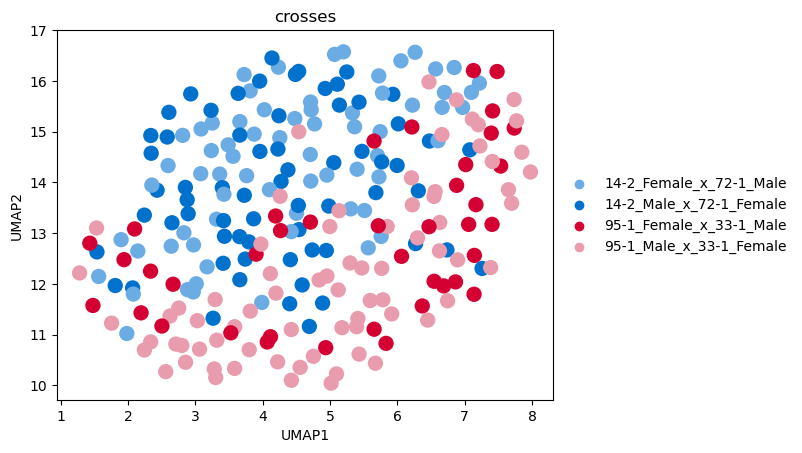

In [119]:
from colorir import *
seed = np.random.RandomState(seed=0)
palette = Palette(core_pink = "#D50032", core_blue = "#0072CE", core_orange = "#E87722", core_green = "#64A70B", core_purple = "#93328E", core_turquoise = "#00B0B9",
                 light_pink = "#E89CAE", light_blue = "#6CACE4", light_orange = "#F1BE48", light_green = "#B7BF10", light_purple = "#AF95A6", light_turquoise = "#85B09A",
                 dark_pink = "#A81538", dark_blue = "#003C71", dark_orange = "#BE4D00", dark_green = "#4E5B31", dark_purple = "#3F2A56", dark_turquoise = "#115E67",
                 gray="#D3D3D3")

sc.pp.neighbors(adata, n_neighbors=50, use_rep='X')

# Compute the UMAP

sc.tl.umap(adata, random_state=seed, alpha = 0.5)


# ax = sc.pl.umap(adata, color='crosses',
#                 palette={'95-1_Female_x_72-1_Male': palette.core_pink,
#                          '95-1_Male_x_72-1_Female': palette.core_pink,
#                          '95-1_Male_x_129-1_Female': palette.light_purple,
#                          '95-1_Female_x_129-1_Male': palette.light_purple,
#                          '14-2_Female_x_72-1_Male': palette.core_blue, #
#                          '14-2_Male_x_72-1_Female': palette.core_blue, # 
#                          '95-1_Male_x_72-1_Female': palette.core_orange,
#                          '95-1_Female_x_33-1_Male': palette.core_green, #
#                          '95-1_Male_x_33-1_Female': palette.core_green, #
#                          '95-1_Male_x_10-1_Female': palette.core_purple,
#                          '95-1_Female_x_10-1_Male': palette.core_purple,
#                          '14-2_Female_x_10-1_Male': palette.core_turquoise,
#                          '14-2_Male_x_10-1_Female': palette.core_turquoise,
#                          '14-2_Female_x_60-1_Male': palette.light_pink,
#                          '14-2_Male_x_60-1_Female': palette.light_pink,
#                          '14-2_Female_x_33-1_Male': palette.light_blue,
#                          '14-2_Male_x_33-1_Female': palette.light_blue,
#                          '14-2_Female_x_129-1_Male': palette.light_orange,
#                          '11-2_Male_x_14-2_Female': palette.light_green,
#                          '11-2_Male_x_72-1_Female': palette.light_green
#                         }, show = False)



ax = sc.pl.umap(adata, color='crosses',
           palette={'95-1_Female_x_33-1_Male': palette.core_pink,
                    '95-1_Male_x_33-1_Female': palette.light_pink,
                    '14-2_Male_x_72-1_Female': palette.core_blue,
                    '14-2_Female_x_72-1_Male': palette.light_blue},
                    show = False)

# ax = sc.pl.umap(adata, color='crosses',
#            palette={'95-1_Female_x_33-1_Male': palette.core_pink,
#                     '95-1_Male_x_33-1_Female': palette.light_pink,
#                     '95-1_Female_x_10-1_Male': palette.core_blue,
#                     '95-1_Male_x_10-1_Female': palette.light_blue})

#  ['95-1_Female_x_72-1_Male' 
#  '95-1_Male_x_129-1_Female' '14-2_Female_x_72-1_Male'
#  '14-2_Male_x_72-1_Female' 
#  '95-1_Female_x_33-1_Male' '95-1_Male_x_10-1_Female'
#  '95-1_Female_x_10-1_Male' '14-2_Female_x_10-1_Male'
#  '14-2_Female_x_60-1_Male' '14-2_Male_x_60-1_Female'
#  '14-2_Female_x_33-1_Male' '14-2_Male_x_33-1_Female'
#  '14-2_Female_x_129-1_Male' '95-1_Male_x_33-1_Female'
#  '14-2_Male_x_10-1_Female' '11-2_Male_x_14-2_Female'
#  '11-2_Male_x_72-1_Female']

ax.set_yticks(list(range(int(np.floor(min(adata.obsm['X_umap'][:, 1]))), 
                         int(np.ceil(max(adata.obsm['X_umap'][:, 1]))) + 1, 1)))
ax.set_xticks(list(range(int(np.floor(min(adata.obsm['X_umap'][:, 0]))), 
                         int(np.ceil(max(adata.obsm['X_umap'][:, 0]))) + 1, 1)))
# plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize='x-small')


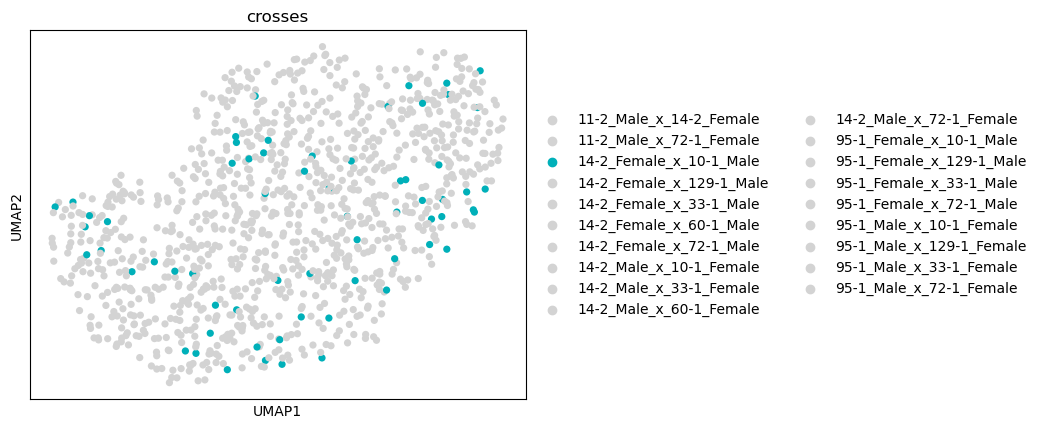

In [75]:
ax = sc.pl.umap(adata, color='crosses', 
                palette={'95-1_Female_x_72-1_Male': palette.gray, # palette.core_pink,
                         '95-1_Male_x_72-1_Female': palette.gray,# palette.core_pink,
                         '95-1_Male_x_129-1_Female': palette.gray,# palette.light_purple,
                         '95-1_Female_x_129-1_Male': palette.gray,# palette.light_purple,
                         '14-2_Female_x_72-1_Male': palette.gray,# palette.core_blue, #
                         '14-2_Male_x_72-1_Female': palette.gray,# palette.core_blue, # 
                         '95-1_Male_x_72-1_Female': palette.gray,# palette.core_orange,
                         '95-1_Female_x_33-1_Male': palette.gray,# palette.core_green,
                         '95-1_Male_x_33-1_Female': palette.gray,# palette.core_green,
                         '95-1_Male_x_10-1_Female': palette.gray,# palette.core_purple,
                         '95-1_Female_x_10-1_Male': palette.gray,# palette.core_purple,
                         '14-2_Female_x_10-1_Male': palette.core_turquoise,
                         '14-2_Male_x_10-1_Female': palette.gray,# palette.core_turquoise,
                         '14-2_Female_x_60-1_Male': palette.gray,# palette.light_pink,
                         '14-2_Male_x_60-1_Female': palette.gray,# palette.light_pink,
                         '14-2_Female_x_33-1_Male': palette.gray,# palette.light_blue,
                         '14-2_Male_x_33-1_Female': palette.gray,# palette.light_blue,
                         '14-2_Female_x_129-1_Male': palette.gray,# palette.light_orange,
                         '11-2_Male_x_14-2_Female': palette.gray,# palette.light_green,
                         '11-2_Male_x_72-1_Female': palette.gray,# palette.light_green
                        })

In [62]:
adata.obs.columns

Index(['crosses', 'plates'], dtype='object')

In [120]:
import umap

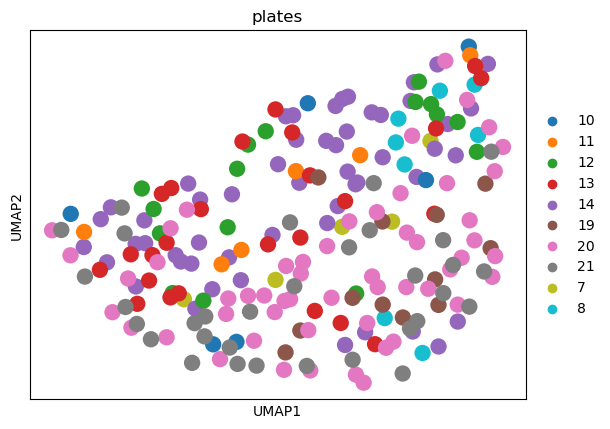

In [164]:
sc.pl.umap(adata, color='plates')

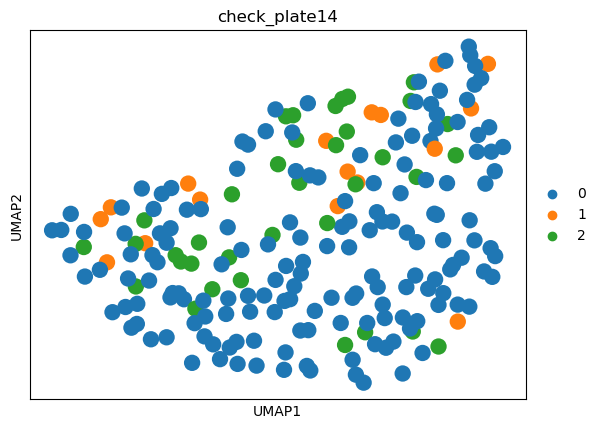

In [171]:
sc.pl.umap(adata, color='check_plate14')

In [165]:
frequency_table = pd.crosstab(distinct_genomes_plate['crosses'], distinct_genomes_plate['plate_number'])
frequency_table

plate_number,10,11,12,13,14,19,20,21,7,8
crosses,,,,,,,,,,
95-1_Female_x_10-1_Male,2,6,0,0,20,1,9,11,0,6
95-1_Female_x_33-1_Male,3,0,9,0,16,0,0,8,4,0
95-1_Male_x_10-1_Female,1,0,1,3,16,11,0,13,1,2
95-1_Male_x_33-1_Female,0,0,6,22,1,0,45,0,0,0


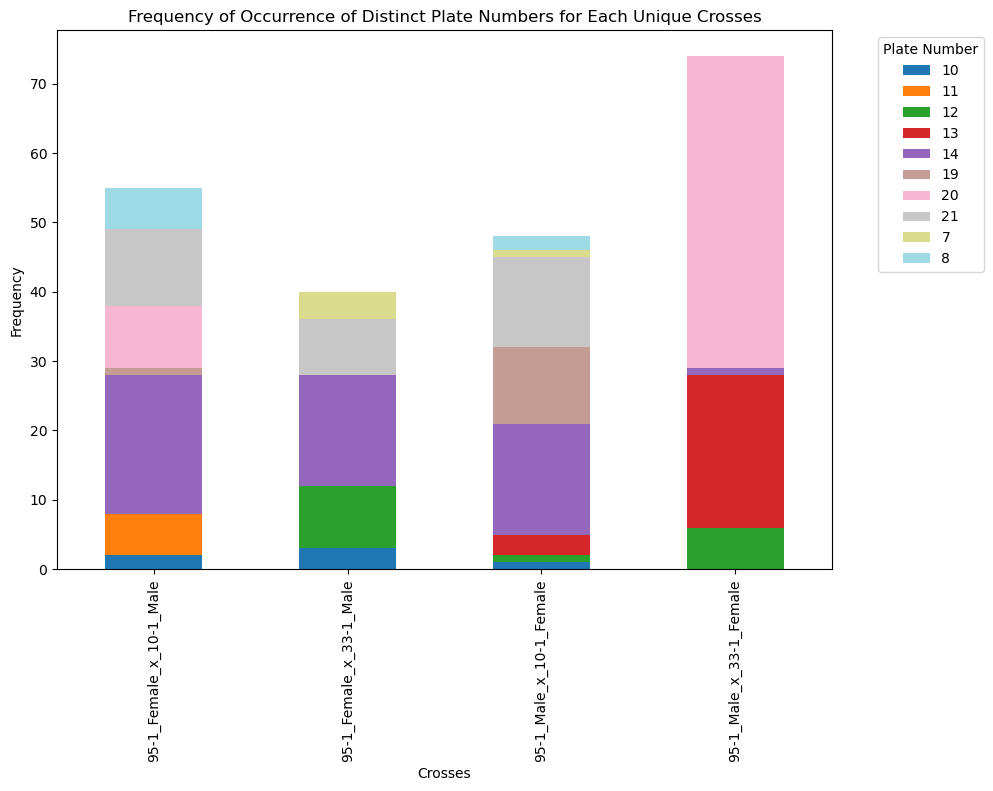

In [166]:
from matplotlib.colors import ListedColormap
colors = [
    "#042333ff", "#0c2a50ff", "#13306dff", "#253582ff", "#403891ff", "#593d9cff",
    "#6b4596ff", "#7e4e90ff", "#90548bff", "#a65c85ff", "#b8627dff", "#cc6a70ff",
    "#de7065ff", "#eb8055ff", "#f68f46ff", "#f9a242ff", "#f9b641ff", "#f7cb44ff",
    "#efe350ff", "#e8fa5bff"
]
# custom_cmap = ListedColormap(colors)
custom_cmap = plt.get_cmap('gist_rainbow')

frequency_table.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='tab20')
plt.xlabel('Crosses')
plt.ylabel('Frequency')
plt.title('Frequency of Occurrence of Distinct Plate Numbers for Each Unique Crosses')
plt.legend(title='Plate Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Sample from class centers

In [130]:
latents_mean = []
latents_std = []

for index, row in mean_df.iterrows():
    mean = torch.tensor(row.values)
    var = torch.tensor(var_df.loc[index].values)
    std = torch.exp(var*0.5)
    
    latents_mean.append(mean)
    latents_std.append(std)

latents_mean = torch.cat(latents_mean, dim=0)
latents_std = torch.cat(latents_std, dim=0)
labels = mean_df.index

In [135]:
latents_mean

tensor([ -8.7138,  -6.4369,   8.3941,  ..., -14.8788,  -3.5213,   1.1953],
       dtype=torch.float64)

In [133]:
merged_df

,img_name,crosses,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,-8.713104,-6.436927,8.394370,-5.193372,-3.644801,2.041743,-1.741984,7.733207,...,-3.430225,-13.526212,4.708737,7.314712,-4.016937,13.533698,18.391561,-2.313736,-0.600999,-19.271465
1,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,-1.736034,22.509992,-27.698583,-15.297254,1.737865,4.024383,-10.183223,3.767878,...,-6.298482,-6.490471,-2.765735,6.051305,10.863448,7.061779,-21.786788,-8.908775,14.249929,-19.298629
3,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,10.156774,14.131744,13.808443,-1.133759,-8.133179,-21.214822,-2.470636,30.609519,...,8.346738,10.027781,-14.122810,13.281317,-4.415345,10.008965,20.022893,-14.408843,35.557977,-5.666168
4,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,7.180072,-3.373941,-7.709398,-12.768094,8.039851,1.081883,15.438581,19.667731,...,21.437368,1.750428,-0.122281,4.326084,0.767469,22.251274,23.113062,-1.047398,-12.419431,-10.082276
8,PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_...,95-1_Female_x_72-1_Male,5.794496,-15.744920,-12.763726,-7.422245,7.894600,-3.332744,1.008972,11.390894,...,-1.792417,-20.718892,1.645563,-11.980459,16.602578,7.948997,4.114233,5.412760,5.238133,-22.047895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,11.337460,12.728316,-15.288677,-9.154100,2.130469,2.294492,3.422788,-2.848268,...,6.592116,0.059933,5.702895,-23.737221,-0.031181,-13.496257,-13.184738,-9.238482,0.426056,-15.807322
2114,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,7.902089,-4.358928,10.745175,5.898535,2.358443,9.347437,-0.406364,-2.045427,...,-1.093329,-2.097899,-12.953636,0.913199,-1.651939,4.574995,6.487942,-4.749044,14.549166,2.528460
2115,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,14.219958,7.144846,-36.182298,-13.255919,3.453943,14.602367,-8.062391,-6.003300,...,2.582177,-10.113947,8.018920,-0.439097,-9.639655,-16.800773,-46.123032,-8.604670,-16.486767,-3.164152
2117,PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F1...,11-2_Male_x_72-1_Female,11.051399,-3.112149,-16.568224,-8.525603,4.848836,16.982072,7.304628,2.559066,...,12.892938,-7.183412,0.638910,2.527154,-2.066912,-3.038636,-11.677966,-13.318078,-11.762324,2.192975


In [134]:
for i in labels:
    class_id = merged_df.loc[merged_df['img_name'] == i, 'crosses'].values[0]
    
    latents_mean_class = latents_mean

95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_72-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Male
95-1_Female_x_129-1_Ma

In [128]:
latents_mean

[tensor([-8.7138e+00, -6.4369e+00,  8.3941e+00, -5.1934e+00, -3.6448e+00,
          2.0417e+00, -1.7420e+00,  7.7337e+00, -2.3313e+01, -8.0346e+00,
         -4.0703e+00,  1.0446e+01,  1.4697e+00, -6.3965e-01,  1.5381e+01,
         -3.8468e+00,  8.1243e+00, -6.5934e+00, -1.8651e+00, -6.6325e+00,
          1.5043e+01,  1.0907e+01, -1.5516e+01,  7.5121e+00,  1.2482e+01,
         -1.7689e-02, -1.0137e+01, -8.0690e+00, -3.7647e+00,  1.5423e+01,
          1.4748e+01, -9.6714e+00, -1.9266e+00,  4.6407e+00, -2.8635e+00,
          7.4087e+00, -1.8373e+01, -2.5841e+00,  9.5934e+00, -4.9113e+00,
         -3.8176e+00, -4.1150e+00, -1.7285e+01,  1.0383e+01, -2.2302e+01,
          2.1053e+01,  6.0428e+00,  1.1386e+01, -8.6054e+00,  5.4424e+00,
         -9.1767e-01,  5.3159e+00, -3.8062e+00,  8.6586e-01, -5.4989e+00,
          2.0449e+01,  3.3147e+00, -2.0190e+01,  2.3695e+01,  1.7211e+01,
          2.6995e+01, -2.1855e+00, -3.1743e+01, -3.0670e+00, -1.1736e+01,
         -9.4845e+00, -6.7973e+00,  3.

### Linear interpolation

In [ ]:
def linear_interpolation(start, end, steps):
    # Create a linear path from start to end
    z = torch.linspace(0, 1, steps)[:, None].to(device) * (end - start) + start
    # Decode the samples along the path
    vae.eval()
    with torch.no_grad():
      samples = vae.decoder(z)
    return samples

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 2 # Number of distinct genetic crosses
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(mean_df)

# clusters = kmeans.predict(mean_df)
clusters = kmeans.predict(distinct_genomes.drop(columns=['img_name', 'crosses']))

In [ ]:
clusters.shape

In [ ]:
print(kmeans.cluster_centers_.shape)

In [ ]:
distinct_genomes.iloc[:, 1]

In [ ]:
print(color_map)

In [ ]:
colors = cluster_data['crosses'].map(color_map)
colors

In [ ]:
handles

In [ ]:
color_map

In [ ]:
colors

In [ ]:
pd.Series(['14-2_Female_x_72-1_Male',
 '14-2_Male_x_72-1_Female',
 '95-1_Female_x_33-1_Male',
 '95-1_Male_x_33-1_Female']).map(color_map)

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 10))

axes = (2,3)

# handles = [mpatches.Patch(color=plt.cm.tab20(color_map[cross]), label=cross) for cross in unique_crosses]
# plt.legend(handles=handles, title="Crosses")

unique_crosses = distinct_genomes['crosses'].unique()
color_map = {cross: idx for idx, cross in enumerate(unique_crosses)}
print(color_map)

handles = [mpatches.Patch(color=plt.cm.viridis(color_map[cross]), label=cross) for cross in unique_crosses]

for cluster in np.unique(clusters):
    cluster_data = distinct_genomes[clusters == cluster] # Get all the rows in this cluster
    colors = cluster_data['crosses'].map(color_map)
    for cross in unique_crosses:
        plt.scatter(cluster_data.iloc[:, axes[0]], cluster_data.iloc[:, axes[1]], c=colors)
    

centers = kmeans.cluster_centers_
plt.scatter(centers[:, axes[0]], centers[:, axes[1]], c='black', s=200, alpha=0.5)

# plt.legend(handles,
        #    ['14-2_Female_x_72-1_Male','14-2_Male_x_72-1_Female','95-1_Female_x_33-1_Male','95-1_Male_x_33-1_Female'])
plt.xlabel(f'Latent dimension {axes[0]}')
plt.ylabel(f'Latent dimension {axes[1]}')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))

axes = (1, 2)

for cluster in np.unique(clusters):
    plt.scatter(mean_df[clusters == cluster].iloc[:, axes[0]], mean_df[clusters == cluster].iloc[:, axes[1]], label=cluster)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, axes[0]], centers[:, axes[1]], c='black', s=200, alpha=0.5)

plt.xlabel(f'Latent dimension {axes[0]}')
plt.ylabel(f'Latent dimension {axes[1]}')
plt.show()

In [ ]:
clusters.shape

In [ ]:
resnet = models.resnet18(pretrained=False)
summary(resnet, (1, 3, 224, 224))

In [ ]:
from models import VariationalAutoEncoderResNet

vae = VariationalAutoEncoderResNet((3, 224, 224), latent_dim=128)
summary(vae, (1, 3, 224, 224))

In [ ]:
import __init__

In [ ]:
config = __init__.load_config("/nfs/research/birney/users/esther/medaka-img/src_files/wandb_yaml/vae-v0.yaml")
print(config)

In [ ]:
if ("image_size" in config.keys()):
    print(True)
else:
    print(False)

In [ ]:
print(torch.cuda.memory_allocated())

In [ ]:
print(torch.cuda.max_memory_allocated())

In [ ]:
torch.cuda.current_device()

In [ ]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # Should return the name of the GPU

In [ ]:
device_properties = torch.cuda.get_device_properties(torch.cuda.current_device())
print(f"Total memory: {device_properties.total_memory / (1024 ** 3)} GB")

In [ ]:
from models import GenomicClassifier, VariationalAutoEncoderResNet

In [ ]:
model = VariationalAutoEncoderResNet(input_dim=(1, 224, 224), latent_dim=128)

summary(model)

In [ ]:
print(model)

In [ ]:
# model = GenomicClassifier(input_dim=(1, 980, 980), latent_dim=200000, num_classes=117670, device=device)

In [ ]:
def model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    param_memory = total_params * 4  # Assuming float32 (4 bytes)
    param_memory_MB = param_memory / (1024 ** 2)  # Convert to MB
    return param_memory_MB
# Example Usage
model = GenomicClassifier(input_dim=(1, 980, 980), latent_dim=66667, num_classes=39223, device=device).to(device)
print(f"Model Parameters Memory: {model_size(model):.2f} MB")

In [ ]:
summary(model, input_size=(1, 1, 980, 980))

In [ ]:
from models import VariationalAutoEncoder

vae = VariationalAutoEncoder(input_dim=(1, 224, 224), latent_dim=128)

In [ ]:
summary(vae, input_size=(1, 1, 224, 224))